In [26]:
# Treino do modelo com hiperparâmetros selecionados
import torch
import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

ENV_ID = 'BipedalWalker-v3'
torch.manual_seed(1)

train_env = Monitor(gymnasium.make(ENV_ID, hardcore = True) )

best_model = PPO('MlpPolicy', train_env, policy_kwargs= dict(net_arch = dict(pi=[64, 128], vf=[64, 128])))

seeds = [1, 2, 3, 5, 8] #, 13, 21, 34, 55, 89]
for seed in seeds:
    best_model.set_random_seed(seed)
    best_model.learn(total_timesteps=int(2e5))

eval_env = Monitor(gymnasium.make(ENV_ID))
_, _ = evaluate_policy(best_model, eval_env, n_eval_episodes=int(1e3), return_episode_rewards = False)

In [25]:
# Visualização
import gymnasium
from stable_baselines3.ppo import PPO

def teste(best_model: PPO):
    env = gymnasium.make(ENV_ID, hardcore = True, render_mode = 'human')
    obs = env.reset()[0]
    i = 0
    seeds = [1, 2, 3, 5, 8]
    while i < 5:
        best_model.set_random_seed(seeds[i])
        action, _ = best_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            obs, info = env.reset()
            i = i + 1
    env.close()

teste(best_model)

In [14]:
best_model.save(ENV_ID)

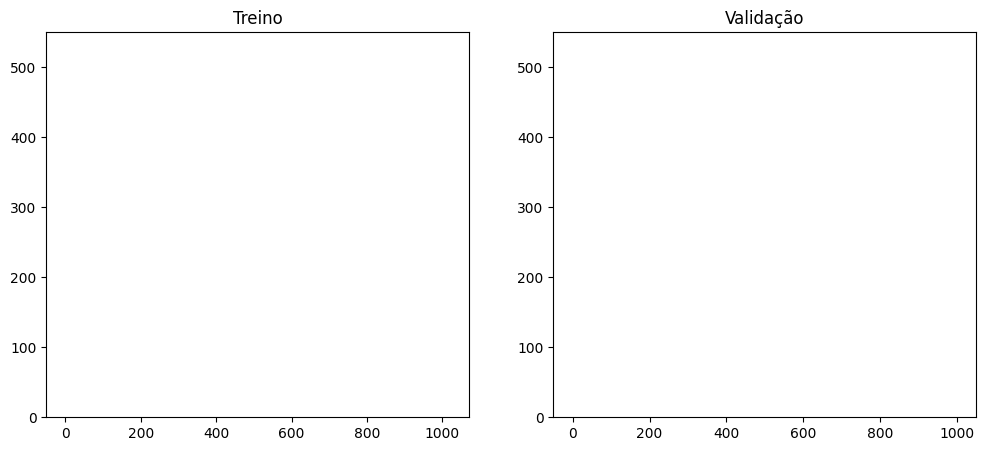

In [8]:
# Resultado do treino e validação
import matplotlib.pyplot as plt
import numpy as np

train_rewards = np.array(train_env.get_episode_rewards())
eval_rewards = np.array(eval_env.get_episode_rewards())

figs, axs = plt.subplots(1,2, figsize=(12, 5))
axs[0].plot(train_rewards)
axs[0].set_ylim(0, 550)
axs[0].set_title('Treino')

axs[1].plot(eval_rewards)
axs[1].set_ylim(0, 550)
axs[1].set_title('Validação')

plt.show()